# Ch10 Exercise 10


Exercise: Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). 

See if you can get over 98% precision. 

Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). 

Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [8]:
# Setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras
assert keras.__version__ >= "2.2.0"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Load the dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
X_train_full.shape

(60000, 28, 28)

In [5]:
# Each pixel intensity is also represented as a byte (0 to 255):
X_train_full.dtype

dtype('uint8')

In [6]:
# Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

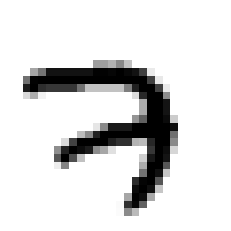

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [10]:
# The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a class_names array:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [11]:
X_valid.shape

(5000, 28, 28)

In [12]:
X_test.shape

(10000, 28, 28)

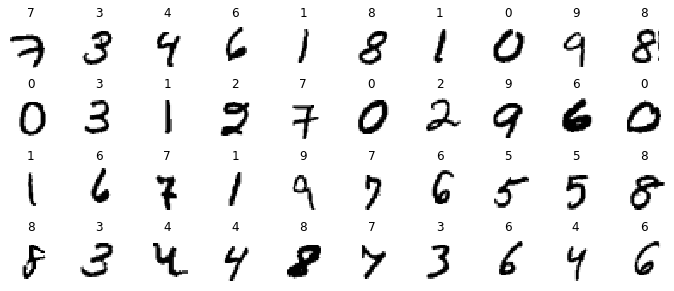

In [13]:
# Let's take a look at a sample of the images in the dataset:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [35]:
# Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [36]:
# Clear the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
# Create the Model:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [38]:
# Compile the model

# We will start with a small learning rate of 1e-3 and grow it by 0.5% at each iteration.

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1e-3),
    metrics=["accuracy"],
)

exponential_lr_cb = ExponentialLearningRate(factor=1.005)

In [39]:
# Train the model for just 1 epoch:
history = model.fit(
    X_train, y_train, 
    epochs=1, 
    validation_data=(X_valid, y_valid),
    callbacks=[exponential_lr_cb]
)

1719/1719 [==============================] - 1s 824us/step - loss: nan - accuracy: 0.5731 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

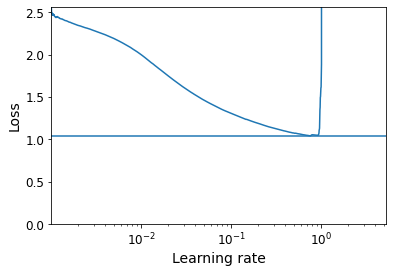

In [40]:
plt.plot(exponential_lr_cb.rates, exponential_lr_cb.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exponential_lr_cb.losses), min(exponential_lr_cb.rates), max(exponential_lr_cb.rates))
plt.axis([min(exponential_lr_cb.rates), max(exponential_lr_cb.rates), 0, exponential_lr_cb.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [41]:
# The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

In [42]:
# Reset the run
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [45]:
# Create the logs for our graphs
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [46]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/100
   1/1719 [..............................] - ETA: 0s - loss: 2.5649 - accuracy: 0.0625WARNING:tensorflow:From C:\Users\frede\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 1s 680us/step - loss: 0.2376 - accuracy: 0.9273 - val_loss: 0.1056 - val_accuracy: 0.9672
Epoch 2/100
1719/1719 [==============================] - 1s 622us/step - loss: 0.0940 - accuracy: 0.9714 - val_loss: 0.0901 - val_accuracy: 0.9740
Epoch 3/100
1719/1719 [==============================] - 1s 613us/step - loss: 0.0653 - accuracy: 0.9792 - val_loss: 0.0780 - val_accuracy: 0.9780
Epoch 4/100
1719/1719 [==============================] - 1s 611us/step - loss: 0.0468 - accuracy: 0.9850 - val_loss: 0.0759 - val_accuracy: 0.9794
Epoch 5/100
171

In [47]:
model = keras.models.load_model("my_mnist_model.h5") # roll back to the best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 382us/step - loss: 0.0649 - accuracy: 0.0982


[0.06494415551424026, 0.0982000008225441]

In [49]:
# Lastly check out the learning curves using Tensorboard

# $ tensorboard --logdir=./my_mnist_logs --port=6006